Setup
====

In [9]:
# class_system = 'USPC'
# data_directory = '../data/'
target_year = 2010

In [10]:
import pandas as pd
import powerlaw
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
import seaborn as sns
sns.set_color_codes()

In [12]:
import pylab
pylab.rcParams['xtick.major.pad']='4'
pylab.rcParams['ytick.major.pad']='4'
pylab.rcParams['figure.subplot.left']='0'
pylab.rcParams['figure.subplot.right']='1'
pylab.rcParams['figure.subplot.bottom']='0'
pylab.rcParams['figure.subplot.top']='1'
pylab.rcParams['savefig.pad_inches']='0'
#pylab.rcParams['font.sans-serif']='Arial'

from matplotlib import rc
rc('font', family='sans-serif')
rc('font', size=10.0)
rc('text', usetex=False)


from matplotlib.font_manager import FontProperties

panel_label_font = FontProperties().copy()
panel_label_font.set_weight("bold")
panel_label_font.set_size(10.0)
panel_label_font.set_family("sans-serif")

In [13]:
from scipy.constants import golden
sns.set_style("darkgrid")
fig_one_col = 3.4252#3.35
fig_two_col = 7.007874#6.93

In [14]:
def add_panel_label(ax=None,
               letter=None,
               coord=None):
    global panel_label
    if letter is None:
        letter = panel_label
        panel_label = chr(ord(panel_label) + 1)
    if ax is None:
        ax = gca()
    if coord is None:
        coord = annotate_coord
    
    ax.text(coord[0], coord[1], letter, 
        transform=ax.transAxes, fontproperties=panel_label_font)

In [15]:
figures = []
# figures_directory = '../manuscript/figs/'
# save_as_manuscript_figures = True

In [16]:
def pretty_axis_labels(ax=None, wraplength=30, **kwargs):
    import textwrap
    if not ax:
        ax = gca()
    x = ax.get_xlabel()
    y = ax.get_ylabel()
    ax.set_xlabel("\n".join(textwrap.wrap(x.replace("_"," "), wraplength)), **kwargs)
    ax.set_ylabel("\n".join(textwrap.wrap(y.replace("_"," "), wraplength)), **kwargs)  
    
def pretty_titles(ax=None, wraplength=30, **kwargs):
    import textwrap
    if not ax:
        ax = gca()
    t = ax.get_title()
    ax.set_title("\n".join(textwrap.wrap(t.replace("_"," "), wraplength)), **kwargs)
    
def pretty_tick_labels(ax=None, wraplength=30,axis='y', **kwargs):
    import textwrap
    if not ax:
        ax = gca()
    if 'x' in axis:
        X = ax.get_xticklabels()
        ax.set_xticklabels(["\n".join(textwrap.wrap(x.get_text().replace("_"," "), wraplength)) for x in X], **kwargs)
    if 'y' in axis:
        Y = ax.get_yticklabels()
        ax.set_yticklabels(["\n".join(textwrap.wrap(y.get_text().replace("_"," "), wraplength)) for y in Y], **kwargs)  

In [17]:
def clean_measure_names(df, include_country=False):
    

    renames = [('Class_Cites_Class_Count', 
                'Direct Citation'),
               ('Class_CoCitation_Count', 
                'Co-Citation'),
               ('Class_Cites_Class_Input_Cosine_Similarity', 
                'Cosine Sim.,\nInputs'),
               ('Class_Cites_Class_Output_Cosine_Similarity', 
                'Cosine Sim.,\nOutputs'),
               ('Class_Cites_Patent_Input_Cosine_Similarity', 
                'Cosine Sim.,\nInputs, High Res.'),
               ('Patent_Cites_Class_Output_Cosine_Similarity', 
                'Cosine Sim.,\nOutputs, High Res.'),
#                ('Class_CoClassification_Count', 
#                 'Co-Classification'),
               ('Class_CoOccurrence_Count_PID', 
                'Co-Classification'),               
               ('Class_CoOccurrence_Count_Inventor', 
                "Co-Occurrence,\nInventors' Patents"),
               ('Class_CoOccurrence_Count_Firm', 
                "Co-Occurrence,\nFirms' Patents"),
                    ]
    if include_country:
        renames.append(('Class_CoOccurrence_Count_Country', 
                        "Co-Occurrence,\nCountries' Patents")
                      )
    new_metric_names = pd.DataFrame(renames, columns=["Old_Name",
                                                     "New_Name"])
    
    rename_dictionary = {}
    for i in new_metric_names.index:
        rename_dictionary[new_metric_names.ix[i,"Old_Name"]] = new_metric_names.ix[i,"New_Name"]
#     df.rename(rename_dictionary, inplace=True)

#     for metric in df.items:
#         if metric not in new_metric_names["New_Name"].values:
#             df.drop(metric, inplace=True,axis='items')
#     return
    return df.rename(items=rename_dictionary).reindex_axis(new_metric_names["New_Name"], axis='items')

def drop_diagonal(df):
    if df.ndim==4:
        for label in df.labels:
            for item in df.items:
                fill_diagonal(df[label, item].values, 0)
    else:
        for item in df.items:
            fill_diagonal(df[item].values, 0)
        
def off_diagonal(df):
    return extract(1 -  eye(len(df)), df)

def remove_empty_classes(df):
    if df.ndim==4:
        df_copy = df.sum(axis=0)
    else:
        df_copy = df
    bad_ind = where(sum(df_copy.fillna(0).sum(axis=0)==0)==df_copy.shape[-1])[0]
    df.drop(df.major_axis[bad_ind], axis='major_axis', inplace=True)
    df.drop(df.minor_axis[bad_ind], axis='minor_axis', inplace=True)

In [18]:
networks_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')

In [19]:
# networks_store2 = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks_backup.h5')
# networks_store.put('/empirical_USPC', networks_store2['empirical_USPC'], 'table', append=False) 

In [20]:
empirical = networks_store['empirical_%s'%class_system].ix[:, target_year]
empirical = clean_measure_names(empirical)
drop_diagonal(empirical)

Size and Time Structure of Citations
===

In [21]:
citations_store = pd.HDFStore(data_directory+'citations_organized.h5')

In [22]:
citations = citations_store['citations']

In [23]:
class_lookup = citations_store['%s_class_lookup'%class_system]
patent_attributes = citations_store['patent_attributes']

In [24]:
print("%i patents"%patent_attributes.shape[0])

3911054 patents


In [25]:
for column in citations.columns:
    if class_system in column:
        new_name = column.replace('_'+class_system, "")
        citations.rename(columns={column: new_name}, inplace=True)

In [26]:
for column in patent_attributes.columns:
    if class_system in column:
        new_name = column.replace('_'+class_system, "")
        patent_attributes.rename(columns={column: new_name}, inplace=True)

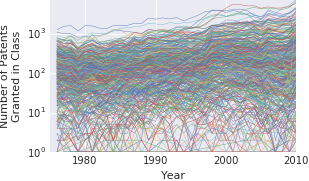

In [20]:
class_counts = pd.DataFrame(patent_attributes.groupby(['Class', 'Year'])['Class'].count())
class_counts.rename(columns={"Class": "Count"}, inplace=True)
class_counts.reset_index(inplace=True)

fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

for this_class in class_lookup.values:
    this_df = class_counts[class_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Count'], linewidth=.4)

xticks([1980, 1990, 2000, 2010])
yscale('log')
ylim(ymax=max(class_counts['Count']))
ylabel("Number of Patents\nGranted in Class")
xlabel("Year")
sns.despine()

In [ ]:
# class_citation_counts = pd.DataFrame(citations.groupby(['Class_Citing_Patent', 'Year_Citing_Patent'])['Same_Class'].count()).reset_index()
# class_citation_counts.rename(columns={'Class_Citing_Patent': 'Class',
#                                      'Year_Citing_Patent': 'Year',
#                                      'Same_Class': 'Count'},
#                             inplace=True)
# class_citation_counts =(class_citation_counts.set_index(['Class', 'Year']) / 
#                         class_counts.set_index(['Class', 'Year'])).reset_index()
class_citation_counts = pd.DataFrame(patent_attributes.groupby(['Class', 'Year'])['Citations_Made'].mean()).reset_index()

In [ ]:
grouper = citations.groupby(['Class_Citing_Patent', 'Year_Citing_Patent'])['Same_Class']

class_same_class_counts = pd.DataFrame(grouper.sum()/grouper.count())

class_same_class_counts['Different_Class'] = 1-class_same_class_counts['Same_Class']
class_same_class_counts.reset_index(inplace=True)

class_same_class_counts.rename(columns={"Year_Citing_Patent": "Year"}, inplace=True)


fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

for this_class in class_lookup.values:
    this_df = class_same_class_counts[class_same_class_counts['Class_Citing_Patent']==this_class]
    ax.plot(this_df['Year'], this_df['Different_Class'], linewidth=.4)

xticks([1980, 1990, 2000, 2010])
ylabel("Number of Citations\nCiting Outside Own Class")
xlabel("Year")
sns.despine()

In [19]:
###Calculate number of patents in each class

patent_count = patent_attributes['Class'].value_counts()
if class_system=='USPC':
    patent_count = patent_count.ix[class_lookup.ix[["%03d"%i for i in empirical.major_axis]].values].fillna(0)
else:
    patent_count = patent_count.ix[class_lookup.ix[empirical.major_axis].values].fillna(0)
# patent_count = patent_count.ix[valid_classes].fillna(0)
patent_count_links = outer(patent_count.values, patent_count.values)

# ##Number of citing patents and cited patents in each class
# citing_patent_count = citations.drop_duplicates(['Citing_Patent'])['Class_Citing_Patent'].value_counts()
# cited_patent_count = citations.drop_duplicates(['Cited_Patent'])['Class_Cited_Patent'].value_counts()

# ##Need to rearrange to match with our networks' ordering
# citing_patent_count = citing_patent_count.ix[class_lookup.ix[empirical.major_axis].values]
# cited_patent_count = cited_patent_count.ix[class_lookup.ix[empirical.major_axis].values]

# ##Create an link between each class, weighted as the product of the patent counts in each class
# citing_patent_count_links = outer(citing_patent_count.values, citing_patent_count.values)
# cited_patent_count_links = outer(cited_patent_count.values, cited_patent_count.values)

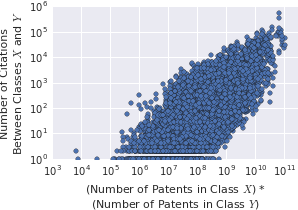

In [22]:
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

ax.scatter(patent_count_links.ravel(),
       empirical.ix['Direct Citation'].values.ravel()
       )
yscale('log')
xscale('log')
ylim(ymin=1)
xlim(xmin=1000, xmax=10**11.5)
# xlim(xmin=1)
sns.despine()
ylabel(r"Number of Citations"+"\n"+"Between Classes $X$ and $Y$")
xlabel(r"(Number of Patents in Class $X$) *"+"\n"+r"(Number of Patents in Class $Y$)")

In [23]:
citations['Year_Difference'] = citations.Year_Citing_Patent - citations.Year_Cited_Patent
year_range = max(citations.Year_Difference)

In [24]:
age_probabilities = citations.groupby('Class_Citing_Patent')['Year_Difference'].apply(lambda d:histogram(d,
                                     bins=arange(year_range+1), 
                                     normed=True
                                    )[0])

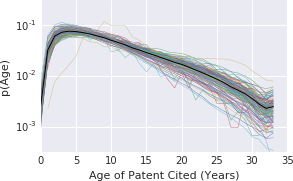

In [25]:
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

for i in age_probabilities.index:
    d = copy(age_probabilities.ix[i])
    d[d==0] = nan
    ax.plot(d, linewidth=.4)
ax.plot(age_probabilities.mean(), color='black', linewidth=1)
xlabel("Age of Patent Cited (Years)")
ylabel("p(Age)")
yscale('log')
ylim(ymin=10**-3.5,
    ymax=10**-.5)

sns.despine()

In [26]:
def expanding_weighted_mean(df):    
    return pd.rolling_apply(arange(len(df)),
                            len(df),
                            lambda ii: average(df.iloc[ii]['Year'], 
                                               weights=df.iloc[ii]['Count']),
                            min_periods=1)

In [27]:
q = class_counts.groupby(['Class'])[['Count', 
                                'Year']].apply(expanding_weighted_mean)
class_counts['Average_Year'] = concatenate(q.values)
class_counts['Average_Age'] = class_counts['Year'] - class_counts['Average_Year']

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


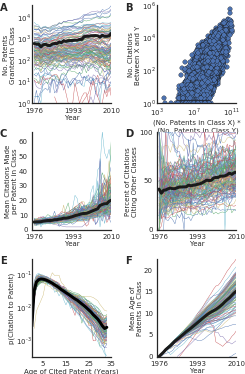

In [29]:
sns.set_style("white")

fig = figure(figsize=(fig_one_col, fig_one_col*.4*2/golden*3.1))
nrows=3
ncols=2

# fig = figure(figsize=(fig_two_col, 6.5))#fig_two_col/1.618))
# nrows=5
# ncols=5

this_ax = 0
annotate_coord = (-.4, .95)
panel_label = "A"

these_font_size = 7
these_label_pad = 1

this_ax +=1
# this_ax = 4
ax = fig.add_subplot(nrows, ncols, this_ax)


for this_class in class_lookup.values:
    this_df = class_counts[class_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Count'], linewidth=.4)

this_df = class_counts.groupby('Year')['Count'].mean()
ax.plot(this_df.index, this_df, linewidth=3, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
yscale('log')
yticks([1, 10, 100, 1000, 10000], fontsize=these_font_size)

ylim(ymax=max(class_counts['Count']))
ylabel("No. Patents\nGranted in Class", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)
ax.tick_params(axis='y', which='major', pad=1)

######
this_ax +=1
# this_ax += ncols
ax = fig.add_subplot(nrows, ncols, this_ax)
ax.scatter(patent_count_links.ravel(),
       empirical.ix['Direct Citation'].values.ravel(),
           c=sns.color_palette()[0]
       )
yscale('log')
xscale('log')
ylim(ymin=1)
xlim(xmin=10**3,xmax=10**11.5)
xticks([10**3, 10**7, 10**11], fontsize=these_font_size)
yticks([1, 10**2, 10**4,10**6], fontsize=these_font_size)
# ylabel(r"No. Citations"+"\n"+r"Between $X$ and $Y$",
#       fontsize=8)
# xlabel(r"(No. Patents in Class $X$) *"+"\n"+r"(No. Patents in Class $Y$)",
#       fontsize=6)

ylabel("No. Citations\nBetween X and Y", 
       fontsize=these_font_size, labelpad=these_label_pad)
xlabel("(No. Patents in Class X) *\n (No. Patents in Class Y)",
      fontsize=these_font_size, labelpad=2)#these_label_pad)

ax.tick_params(axis='both', which='major', pad=1)
ax.tick_params(axis='x', which='major', pad=2)

#####
this_ax += 1#ncols
# this_ax += ncols-1

ax = fig.add_subplot(nrows, ncols, this_ax)

for this_class in class_lookup.values:
    this_df = class_citation_counts[class_citation_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Citations_Made'], linewidth=.4)

this_df = class_citation_counts.groupby('Year')['Citations_Made'].mean()
ax.plot(this_df.index, this_df, linewidth=3, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
ylim(ymax=max(class_citation_counts['Citations_Made']))
#yscale('log')
yticks(fontsize=these_font_size)

ylabel("Mean Citations Made\nper Patent in Class", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)


#####
this_ax +=1
ax = fig.add_subplot(nrows, ncols, this_ax)


for this_class in class_lookup.values:
    this_df = class_same_class_counts[class_same_class_counts['Class_Citing_Patent']==this_class]
    ax.plot(this_df['Year'], this_df['Different_Class']*100, linewidth=.4)

this_df = class_same_class_counts.groupby('Year')['Different_Class'].mean()*100
ax.plot(this_df.index, this_df, linewidth=3, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
yticks([0, 50, 100], fontsize=these_font_size)

ylabel("Percent of Citations\nCiting Other Classes", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)


#####
this_ax +=1
# this_ax += ncols-1
ax = fig.add_subplot(nrows, ncols, this_ax)

for i in age_probabilities.index:
    d = copy(age_probabilities.ix[i])
    d[d==0] = nan
    ax.plot(d, linewidth=.4)
ax.plot(age_probabilities.mean(), color='black', linewidth=3)
xlabel("Age of Cited Patent (Years)", fontsize=these_font_size, labelpad=these_label_pad)
ylabel("p(Citation to Patent)", fontsize=these_font_size, labelpad=these_label_pad)
yscale('log')
ylim(ymin=10**-3.5,
    ymax=10**-.5)
xticks([5, 15, 25, 35], fontsize=these_font_size)
yticks([10**-3, 10**-2, 10**-1], fontsize=these_font_size)

ax.tick_params(axis='y', which='major', pad=0)

####
this_ax +=1
ax = fig.add_subplot(nrows, ncols, this_ax)


for this_class in class_lookup.values:
    this_df = class_counts[class_counts['Class']==this_class]
    ax.plot(this_df['Year'], this_df['Average_Age'], linewidth=.4)

this_df = class_counts.groupby('Year')['Average_Age'].mean()
ax.plot(this_df.index, this_df, linewidth=3, color='k')

xticks([1976, 1993, 2010], fontsize=these_font_size)
# yscale('log')
yticks(fontsize=these_font_size)

ylim(ymax=max(class_counts['Average_Age']))
ylabel("Mean Age of\nPatents in Class", fontsize=these_font_size, labelpad=these_label_pad)
xlabel("Year", fontsize=these_font_size, labelpad=these_label_pad)


for ax in fig.get_axes():
#     ax.tick_params(axis='y', which='major', pad=1)
    sns.despine(fig,ax)
    add_panel_label(ax)

# fig.subplots_adjust(hspace=.5, wspace=.8)

fig.tight_layout(pad=0, w_pad=.1, h_pad=-.8)
# figures.append(fig)

if save_as_manuscript_figures:
    filename = 'Impinging_Factors'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight', pad_inches=0)
    savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight', pad_inches=0)    
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'.eps', bbox_inches='tight')

Ability to rewire links
===
The vast majority of citations are not uniquely determined by the years of their source and target patents, even if we restrict to citations that are between patents of the same class or between patents of different classes. This allows the vast majority of links to be rewired.

In [30]:
same_class_ind = citations['Same_Class']==True
same_class_group_sizes = citations.ix[same_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    'Class_Citing_Patent', 
    ])['Cited_Patent'].count()

cross_class_ind = -same_class_ind
cross_class_group_sizes = citations.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
    'Year_Cited_Patent', 
    ])['Cited_Patent'].count()

group_sizes = concatenate((same_class_group_sizes.values, cross_class_group_sizes.values))

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


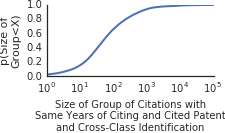

In [31]:
sns.set_style('white')

fig = figure(figsize=(fig_one_col, fig_one_col/1.618))

import powerlaw
x, y = powerlaw.cdf(group_sizes)
plot(x-1, y, linewidth=2)

xscale('log')
xlim(xmax=max(x))
legend(loc=4)

xlabel("Size of Group of Citations with\n"
       "Same Years of Citing and Cited Patent\n"
       "and Cross-Class Identification", fontsize=10)
ylabel("p(Size of\nGroup<X)")

fig.tight_layout()
sns.despine()

figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Citation_Group_Sizes'
    savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
#     savefig(figures_directory+filename+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'.eps', bbox_inches='tight')

In [32]:
x = 100*sum(group_sizes==1)/group_sizes.shape[0]
print("%.2f percent of year and cross-class pairings are unique (1 member in the group)."%x)

x = 100*sum(group_sizes<10)/group_sizes.shape[0]
print("%.2f percent of year and cross-class pairings have fewer than 10 members."%x)

2.55 percent of year and cross-class pairings are unique (1 member in the group).
14.16 percent of year and cross-class pairings have fewer than 10 members.


Number of Same-Class Links Erroneously Created
===

In [33]:
n_cross_class = sum(cross_class_ind)
n_same_class = sum(same_class_ind)
print("In the original network %.2f%% of citations are same-class"%
      (100*n_cross_class/(n_cross_class+n_same_class)))

In the original network 39.74% of citations are same-class


In [34]:
# patent_attributes = pd.read_csv(data_directory+'pid_issdate_ipc.csv')

# patent_attributes.ISSDATE = patent_attributes.ISSDATE.map(lambda x: int(x[-4:]))
# patent_attributes.rename(columns={
#                     'ISSDATE': 'Year',
#                     'IPC3': 'Class',
#                     'PID': 'Patent',
#                     },
#                  inplace=True)
# patent_attributes.set_index('Patent', inplace=True)

# citations_randomized = citations.copy()

# ### Take the same-class citations of every class and permute them.
# same_class_ind = citations_randomized['Same_Class']==True
# citations_randomized.ix[same_class_ind, 'Cited_Patent'] = citations_randomized.ix[same_class_ind].groupby(['Year_Citing_Patent', 
#     'Year_Cited_Patent', 
#     'Class_Citing_Patent', 
#     ])['Cited_Patent'].transform(permutation)

# ### Take the cross-class citations and permute them.
# cross_class_ind = -same_class_ind#citations_randomized['Same_Class']==False
# citations_randomized.ix[cross_class_ind, 'Cited_Patent'] = citations_randomized.ix[cross_class_ind].groupby(['Year_Citing_Patent', 
#     'Year_Cited_Patent', 
#     ])['Cited_Patent'].transform(permutation)

# ### Drop patent attributes (which are now inaccurate for the cited patent) and bring them in from patent_attributes
# citations_randomized = citations_randomized[['Citing_Patent', 'Cited_Patent', 'Same_Class']]

# citations_randomized = citations_randomized.merge(patent_attributes, 
#                 left_on='Citing_Patent', 
#                 right_index=True,
#                 )

# citations_randomized = citations_randomized.merge(patent_attributes, 
#                 left_on='Cited_Patent', 
#                 right_index=True,
#                 suffixes=('_Citing_Patent','_Cited_Patent'))

# n = sum((citations_randomized['Class_Citing_Patent']==citations_randomized['Class_Cited_Patent'] * -citations_randomized['Same_Class']))
# print("%.2f percent of the citations are now erroneously same-class when they should be cross-class"%(100*n/citations_randomized.shape[0]))

Comparing empirical proximity values to those of randomized controls
===

In [34]:
if class_system == 'IPC':
    controls = pd.read_hdf(data_directory+'Class_Relatedness_Networks/class_relatedness_networks_controls_organized_IPC.h5',
                      'controls_%s'%class_system)
    #     metric = 'Co-Citation'
    #     controls = clean_measure_names(controls)
    controls = controls.ix['Class_CoCitation_Count',:,empirical.major_axis, empirical.minor_axis]

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


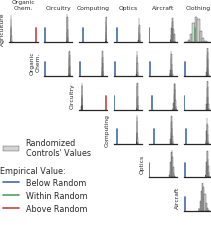

In [35]:
if class_system == 'IPC':
    metric = 'Co-Citation'
    
    fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))
    sns.set_style("white")



    if class_system=='IPC':
        class_labels = pd.read_csv(data_directory+'class_labels_%s.csv'%class_system).set_index('Class')        
        classes_visualized = ["A01", #Agriculture
                              "C07", #Organic Chemistry
                              "H03", #Electric Circuitry                                          
                              "G06", #Computing
                              "G02", #Optics
                              "B64", #Aircraft
                              "A41"] #Railways
    else:
        classes_visualized = empirical.major_axis[:7]
    n_classes_visualized = len(classes_visualized)
    for i in arange(n_classes_visualized):
        for j in arange(n_classes_visualized)[i:]:
            c = controls.ix[:,classes_visualized[i],classes_visualized[j]]

            if i==j:# and allclose(c, 1):
    #            plt.axis('off')
                continue
            else:
                ax = fig.add_subplot(n_classes_visualized,n_classes_visualized,
                                     (i*n_classes_visualized)+j)

                controls_hist = hist(c, color='lightgray')
            e = empirical.ix[metric].ix[classes_visualized[i],classes_visualized[j]]
            empirical_y_coords = (ylim()[0], ylim()[1]*.5)
            empirical_x_coors = (e,e)
            if e<c.min():
                empirical_color=sns.color_palette()[0] #'blue'
                empirical_line_below, = plot(empirical_x_coors, 
                                             empirical_y_coords, 
                                             color=empirical_color)
            elif e>c.max():
                empirical_color=sns.color_palette()[2] #'red'
                empirical_line_above, = plot(empirical_x_coors, 
                                             empirical_y_coords, 
                                             color=empirical_color)
            else:
                empirical_color=sns.color_palette()[1] #'green'
                empirical_line_within, = plot(empirical_x_coors, 
                                             empirical_y_coords, 
                                             color=empirical_color)
    #         empirical_line, = plot((e,e), (ylim()[0], ylim()[1]*.5), color=empirical_color)
            if i==0: #If we're in the first row, label the columns
                if class_labels is not None:
                    cl = class_labels.ix[classes_visualized[j], 'Class_label'].replace(" ", "\n")                            
                else:
                    cl = empirical.major_axis[j]
                ax.set_title(cl, fontsize=6)
            if i+1==j: #If we're at the edge of a row, label the row
                if class_labels is not None:
                    cl = class_labels.ix[classes_visualized[i], 'Class_label'].replace(" ", "\n")                            
                else:
                    cl = empirical.major_axis[i]

                ax.set_ylabel(cl, fontsize=6, labelpad=0)
    #            ax.yaxis.tick_right()
    #        plt.axis('off')
            sns.despine(left=True)
            ax.set_yticklabels([])
            ax.set_xticklabels([])

    fig.legend((controls_hist[-1][0],
                ), 
               ("Randomized\nControls' Values",
                ), 
               (.0,.3),
              fontsize=8)

    fig.text(.0, .29, 'Empirical Value:', fontsize=8)

    fig.legend((
                empirical_line_below, 
                empirical_line_within,
                empirical_line_above,
                ), 
               (
                'Below Random', 
               'Within Random',            
               'Above Random',            
                ), 
               (.0,.06),
              fontsize=8)

    # fig.subplots_adjust(hspace=0.4, 
    #                     wspace=0.4,
    #                    left=0,
    #                    right=.9,
    #                    bottom=0,
    #                    top=.9)
    fig.tight_layout(h_pad=0.4, w_pad=-.9,pad=0)
    figures.append(fig)
    if save_as_manuscript_figures:
        filename = 'Rewiring_Histogram'
        savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
        # savefig(figures_directory+filename+'.svg', bbox_inches='tight')
        # savefig(figures_directory+filename+'.eps', bbox_inches='tight')

Empirical link values are typically very different from randomized controls
======
Most links are weak, some links are strong
---
~70% of links are weaker than would be expected by chance, while the remaining ~20% of links are stronger than expected by chance. Thus, the connectivity network is a sparse network.

In [36]:
store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')

In [37]:
controls_max = clean_measure_names(store['randomized_max_%s'%class_system].ix[:,target_year, empirical.major_axis, empirical.minor_axis])
controls_min = clean_measure_names(store['randomized_min_%s'%class_system].ix[:,target_year, empirical.major_axis, empirical.minor_axis])

In [38]:
summary_table = pd.DataFrame(index=empirical.items,
                            columns=["Below Randomized Controls",
                                     "Within Randomized Controls",
                                     "Above Randomized Controls"
                                     ]
                            )

for metric in empirical.items:
    n_links = product(empirical.ix[metric].shape)-empirical.ix[metric].shape[0]
    above_random = 100*sum(off_diagonal(empirical.ix[metric].values>controls_max.ix[metric].values))/n_links
    below_random = 100*sum(off_diagonal(empirical.ix[metric].values<controls_min.ix[metric].values))/n_links
    within_random = 100-above_random-below_random
    summary_table.ix[metric, "Above Randomized Controls"] = above_random
    summary_table.ix[metric, "Below Randomized Controls"] = below_random
    summary_table.ix[metric, "Within Randomized Controls"] = within_random

In [39]:
summary_table

,Below Randomized Controls,Within Randomized Controls,Above Randomized Controls
New_Name,,,
Direct Citation,51.8229,31.2258,16.9513
Co-Citation,63.6507,20.1187,16.2306
"Cosine Sim.,\nInputs",68.1444,15.3828,16.4729
"Cosine Sim.,\nOutputs",68.5562,16.0853,15.3585
"Cosine Sim.,\nInputs, High Res.",73.9462,16.9453,9.10853
"Cosine Sim.,\nOutputs, High Res.",69.3314,19.4283,11.2403
Co-Classification,0,100,0
"Co-Occurrence,\nInventors' Patents",31.2137,47.093,21.6933
"Co-Occurrence,\nFirms' Patents",12.6696,39.1473,48.1831


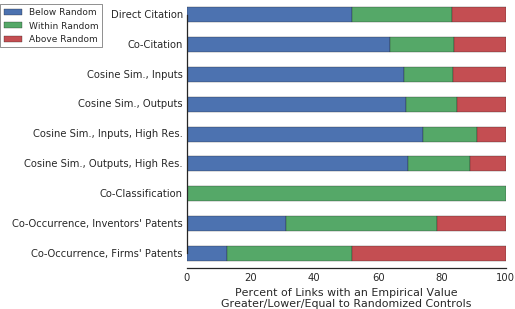

In [40]:
fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
ax = fig.add_subplot(1,1,1)

summary_table.rename(columns={'Below Randomized Controls': 'Below Random',
                              'Within Randomized Controls': 'Within Random',
                              'Above Randomized Controls': 'Above Random'
                             }).iloc[::-1].plot(kind='barh', 
                                        stacked=True, 
                                        legend=False,
                                       ax=ax)
#xlim(xmax=100)

xlabel("Percent of Links with an Empirical Value\n"
       "Greater/Lower/Equal to Randomized Controls")
# ylabel("Relatedness Measure")
ylabel("")
ax.set_yticklabels([x.get_text().replace('\n', ' ') for x in ax.get_yticklabels()])


#pretty_tick_labels(wraplength=20, axis='y')
l = legend(loc="upper left",
       frameon=True,
       shadow=False,
          bbox_to_anchor=[-.6,1],
          fontsize=9)
fr = l.get_frame() 
fr.set_linewidth(.5)

sns.despine(trim=True)

figures.append(fig)

fig.tight_layout(pad=0)
if save_as_manuscript_figures:
    filename = 'Related_Unrelated_Percentages_Two_Column'
    savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')

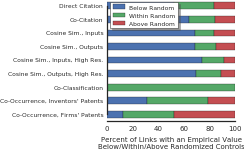

In [41]:
fig = figure(figsize=(fig_one_col, fig_one_col/1.618))
ax = fig.add_subplot(1,1,1)

summary_table.rename(columns={'Below Randomized Controls': 'Below Random',
                              'Within Randomized Controls': 'Within Random',
                              'Above Randomized Controls': 'Above Random'
                             }).iloc[::-1].plot(kind='barh', 
                                        stacked=True, 
                                        legend=False,
                                       ax=ax)
#xlim(xmax=100)

ax.set_yticklabels([x.get_text().replace('\n', ' ') for x in ax.get_yticklabels()],
                  fontsize=6)
#                   rotation=90, ha='center')
xticks(fontsize=7)

xlabel("Percent of Links with an Empirical Value\n"
       "Below/Within/Above Randomized Controls", fontsize=7)
#ylabel("Relatedness Measure", fontsize=8)
ylabel("")


#pretty_tick_labels(wraplength=20, axis='y')
l = legend(loc="upper left",
       frameon=True,
       shadow=True,
          fontsize=6)
fr = l.get_frame() 
fr.set_linewidth(.5)

sns.despine(trim=True)

fig.tight_layout(pad=0)
fig.subplots_adjust(bottom=.2, top=1,left=.43,right=.95, wspace=None, hspace=None, )

figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Related_Unrelated_Percentages'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')

In [42]:
n_positive_links = (empirical>controls_max).sum(axis=1)
print(n_positive_links.min())
for measure in n_positive_links.columns:
    if any(n_positive_links[measure]==0):
        i = where(n_positive_links[measure]==0)[0]
        print('\n'+measure.replace("\n", " "))
        if class_system=='IPC':
            print(class_labels.ix[empirical.major_axis[i], 'Class_label'])

New_Name
Direct Citation                       0
Co-Citation                           0
Cosine Sim.,\nInputs                  0
Cosine Sim.,\nOutputs                 0
Cosine Sim.,\nInputs, High Res.       0
Cosine Sim.,\nOutputs, High Res.      0
Co-Classification                     0
Co-Occurrence,\nInventors' Patents    0
Co-Occurrence,\nFirms' Patents        0
dtype: int64

Direct Citation
A99    NaN
B99    NaN
C99    NaN
D99    NaN
E99    NaN
F99    NaN
G99    NaN
H99    NaN
Name: Class_label, dtype: object

Co-Citation
A99                        NaN
B99                        NaN
C40    Combinatorial Chemistry
C99                        NaN
D99                        NaN
E99                        NaN
F99                        NaN
G99                        NaN
H99                        NaN
Name: Class_label, dtype: object

Cosine Sim., Inputs
A99    NaN
B99    NaN
C99    NaN
D99    NaN
E99    NaN
F99    NaN
G99    NaN
H99    NaN
Name: Class_label, dtype: object

Cosine Sim.,

In [76]:
# print("Correlation of direct citations in both directions for\n"
#       "Empirical: %.2f\n"
#       "Normalized: %.2f"%(pearsonr(off_diagonal(empirical['Direct Citation'].values),
#                                    off_diagonal(empirical['Direct Citation'].values.T),
#                                   )[0],
#                           pearsonr(off_diagonal(z_scores['Direct Citation'].fillna(0).values),
#                                    off_diagonal(z_scores['Direct Citation'].fillna(0).values.T),
#                                   )[0]
#                           )
#       )

Co-Occurrence data that preserves year-by-year class and entity counts, vs. not
===

In [77]:
if class_system =='IPC':
    unpreserved_years_controls_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/cooccurrence/class_relatedness_networks_cooccurrence_no_preserve_years.h5')

    unpreserved_years_controls_max = clean_measure_names(unpreserved_years_controls_store['randomized_max_%s'%class_system].ix[:,target_year, empirical.minor_axis, empirical.major_axis])
    unpreserved_years_controls_min = clean_measure_names(unpreserved_years_controls_store['randomized_min_%s'%class_system].ix[:,target_year, empirical.minor_axis, empirical.major_axis])

    drop_diagonal(unpreserved_years_controls_max)
    drop_diagonal(unpreserved_years_controls_min)

    summary_table = pd.DataFrame(columns=["Below Randomized Controls",
                                         "Within Randomized Controls",
                                         "Above Randomized Controls"
                                         ]
                                )

    for metric in unpreserved_years_controls_max.items:
        if 'Co-' not in metric or metric=='Co-Citation':
            continue
        n_links = product(empirical.ix[metric].shape)-empirical.ix[metric].shape[0]

        above_random = 100*sum(off_diagonal(empirical.ix[metric].values>controls_max.ix[metric].values))/n_links
        below_random = 100*sum(off_diagonal(empirical.ix[metric].values<controls_min.ix[metric].values))/n_links
        within_random = 100-above_random-below_random

        summary_table.ix[metric, "Above Randomized Controls"] = above_random
        summary_table.ix[metric, "Below Randomized Controls"] = below_random
        summary_table.ix[metric, "Within Randomized Controls"] = within_random

        above_random = 100*sum(off_diagonal(empirical.ix[metric].values>unpreserved_years_controls_max.ix[metric].values))/n_links
        below_random = 100*sum(off_diagonal(empirical.ix[metric].values<unpreserved_years_controls_min.ix[metric].values))/n_links
        within_random = 100-above_random-below_random

        summary_table.ix[metric+',+Unpreserved Year Sequence', "Above Randomized Controls"] = above_random
        summary_table.ix[metric+',+Unpreserved Year Sequence', "Below Randomized Controls"] = below_random
        summary_table.ix[metric+',+Unpreserved Year Sequence', "Within Randomized Controls"] = within_random

        summary_table

    fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
    ax = fig.add_subplot(1,1,1)

    summary_table.rename(columns={'Below Randomized Controls': 'Below Random',
                              'Within Randomized Controls': 'Within Random',
                              'Above Randomized Controls': 'Above Random'
                             }).iloc[::-1].plot(kind='barh', 
                                            stacked=True, 
                                            legend=False,
                                           ax=ax)

    xlabel("Percent of Links with an Empirical Value\n"
           "Greater/Lower/Equal to Randomized Controls")
    ylabel("")
    ax.set_yticklabels([x.get_text().replace('\n', ' ') for x in ax.get_yticklabels()])
    ax.set_yticklabels([x.get_text().replace('+', '\n') for x in ax.get_yticklabels()])


    #pretty_tick_labels(wraplength=20, axis='y')
    l = legend(loc="upper left",
           frameon=True,
           shadow=False,
              bbox_to_anchor=[-.65,1],
              fontsize=9)
    fr = l.get_frame() 
    fr.set_linewidth(.5)

    sns.despine()
    fig.tight_layout(pad=0)
    figures.append(fig)

    if save_as_manuscript_figures:
        filename = 'CoOccurrence_Year_Preservation_Comparison'
        savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')

The Space of Possible Z-scores Growing with Class' Patent Count, Causing Z-Scores to Inflate in Magnitude. We Deflate the Z-Scores to Counteract this Effect.
===

In [27]:
networks_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')

In [28]:
z_scores = clean_measure_names(networks_store['empirical_z_scores_%s'%class_system].ix[:, target_year])
if class_system in ['IPC',] and target_year>2006:
    z_scores['Co-Classification'] = clean_measure_names(networks_store['empirical_z_scores_%s'%class_system].ix[:, 
                                                                                                                2006])['Co-Classification']
z_scores.values[where(z_scores==inf)]=nan 
z_scores.fillna(0,inplace=True)

valid_classes = z_scores.major_axis
empirical = clean_measure_names(networks_store['empirical_%s'%class_system].ix[:, target_year])
rand_mean = clean_measure_names(networks_store['randomized_mean_%s'%class_system].ix[:, target_year])
rand_std = clean_measure_names(networks_store['randomized_std_%s'%class_system].ix[:, target_year])
empirical = empirical.ix[:, valid_classes, valid_classes]
rand_mean = rand_mean.ix[:, valid_classes, valid_classes]
rand_std = rand_std.ix[:, valid_classes, valid_classes]

In [29]:
patent_count = patent_attributes['Class'].value_counts()
if class_system=='USPC':
    patent_count = patent_count.ix[class_lookup.ix[["%03d"%i for i in z_scores.major_axis]].values].fillna(0)
else:
    patent_count = patent_count.ix[class_lookup.ix[z_scores.major_axis].values].fillna(0)
patent_count_links = outer(patent_count.values, patent_count.values)

In [30]:
from scipy.stats import linregress, pearsonr

def trend(x,y, with_corr=False):
    slope, intercept, r, p, stderr = linregress(log(x),log(y))
    f = lambda x: x**slope * exp(intercept)
    if with_corr:
        return f, r
    else:
        return f

def trend_up(x,y, with_corr=False):
    return trend(x[y>0], y[y>0], with_corr)

def trend_down(x,y, with_corr=False):
    return trend(x[y<0], abs(y[y<0]), with_corr)

def normalize_out_patent_counts(target, ax=None):
    x, y = patent_count_links.ravel(), target.values.ravel()    
    f_up = trend_up(x,y)
    f_down = trend_down(x,y)
    norm_y_up = y[y>0]/f_up(x[y>0])
    norm_y_down = y[y<0]/f_down(abs(x[y<0]))

    target_norm = target.copy()
    target_norm.values[target_norm.values>0] = norm_y_up
    target_norm.values[target_norm.values<0] = norm_y_down
    return target_norm

In [31]:
deflated_z_scores = z_scores.copy()
for item in deflated_z_scores.items:
        deflated_z_scores.ix[item] = normalize_out_patent_counts(z_scores.ix[item])

In [ ]:
### X and Y are vectors of classes with different sizes (number of patents). 
### The sizes range from 10 to some fraction of N (all patents in all classes).
N = (mean([citations['Cited_Patent'].nunique(), citations['Citing_Patent'].nunique()]) * 
     class_same_class_counts['Different_Class'].mean()) / 2
max_fraction_of_N = 50*(1/121)
X = 10**arange(1.5,log10(N*max_fraction_of_N),.1)
Y = 10**arange(1.5,log10(N*max_fraction_of_N),.1)
XY = X*Y

randomized_mean = (X*Y/N)
randomized_std = sqrt(X*Y/N*(1-Y/N)*(N-X)/N)
analytical_z_score = lambda e: (e-randomized_mean)/randomized_std
#Code from http://stackoverflow.com/a/33162465/897578

In [55]:
def z_score_inflation_plot(measure='Direct Citation', model=False, plot_legend=False,
                          linthreshy=.1):

    sns.set_style("white")

    fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    nrows = 2
    ncols = 2
    this_ax = 0

    this_ax+=1
    ax = fig.add_subplot(nrows, ncols,this_ax)
    scatter(patent_count_links.ravel(),
            rand_mean.ix[measure].values.ravel(),
           s=1, color='b')
    scatter(patent_count_links.ravel(),
            rand_std.ix[measure].values.ravel(),
           s=1, color='g')

    if model:
        plot(XY, randomized_mean)
        plot(XY, randomized_std)


    xscale('symlog')
    yscale('symlog', linthreshy=linthreshy)
    ylim(ymin=nanmin([rand_mean.ix[measure].values.ravel().min(), rand_std.ix[measure].values.ravel().min()]),
                     ymax=rand_mean.ix[measure].values.ravel().max())
    xlim(xmin=patent_count_links.ravel().min(), xmax=patent_count_links.ravel().max())
    multicolor_ylabel(ax, ('Mean,','Standard Deviation'), ("g", "b"), 'y', anchorpad=-2)
    [label.set_visible(False) for label in ax.get_xticklabels()]
    
    ##########
    this_ax+=1
    ax = fig.add_subplot(nrows, ncols,this_ax, sharex=ax)
    x = patent_count_links.ravel()
    y = rand_mean.ix[measure].values.ravel()/rand_std.ix[measure].values.ravel()
    scatter(x,y,
           s=1, color='k')
    if model:
        l1, = plot(XY, randomized_mean/randomized_std, color='k')
    xscale('log')
    yscale('symlog', linthreshy=.01)
    ylim(ymin=nanmin(y))
    xlim(xmin=patent_count_links.ravel().min(), xmax=x.max())
    ylabel("Mean/Standard Deviation")
    # legend(loc='upper left')
    [label.set_visible(False) for label in ax.get_xticklabels()]

    ##########
    this_ax+=1
    ax = fig.add_subplot(nrows, ncols,this_ax, sharex=ax)

    if model:
        x = XY

    #     y = analytical_z_score(XY)
    #     fill_between(x,y, max(y), color = '0.9')
    #     # plot(x,y, label='Maximum possible\n(Empirical value = X*Y)')
    #     text(.01,.9, "Maximum possible\n(Observed value = X*Y)",
    #         transform=ax.transAxes)
    #     y = analytical_z_score(0)
    #     # plot(x,y, label='Minimum possible\n(Empirical value = 0)')
    #     text(.01,.01, "Minimum possible\n(Observed value = 0)",
    #         transform=ax.transAxes)
    #     fill_between(x,y, min(y),  color = '0.9')
        fill_between(x,analytical_z_score(0), analytical_z_score(XY), color='0.9')
        text(x[round(len(x)/4)],analytical_z_score(XY)[round(len(x)/2)]*.8, 
             "Space of Possible Z-scores",
            rotation=7.5)

    x = patent_count_links.ravel()
    y = z_scores.ix[measure].values.ravel()
    l2 = scatter(x,y,
           s=1, color='k')
    yscale('symlog', linthreshy=.01)
    xscale('log')

    f, r = trend_up(x,y, with_corr=True)
    l3, = plot(xlim(), f(xlim()), 'k--')
#     text(.7,.8, "corr. of logs:\n%.2f"%(r),
#         transform=ax.transAxes)

    f, r = trend_down(x,y, with_corr=True)
    print(min(y), max(y))
    print(min(x), max(x))
    plot(xlim(), -f(xlim()), 'k--')
#     text(.7,.3, "corr. of logs:\n%.2f"%(r),
#         transform=ax.transAxes)

    ylim(ymin=y.min())
    xlim(xmin=x.min(), xmax=x.max())

    # legend(loc='upper left', ncol=2)
    ylabel("Z-Scores")
    xlabel("(No. Patents in Class X) *\n(No. Patents in Class Y)")
    [label.set_visible(False) for label in ax.yaxis.get_ticklabels()[::2]]

    ##########
    this_ax+=1
    ax = fig.add_subplot(nrows, ncols,this_ax, sharex=ax)

    x = patent_count_links.ravel()
    y = deflated_z_scores.ix[measure].values.ravel()
    scatter(x,y,
           s=1)
    yscale('symlog', linthreshy=.01)
    xscale('log')

    f, r = trend_up(x,y, with_corr=True)
    plot(xlim(), f(xlim()), 'k--')
#     text(.7,.8, "corr. of logs:\n%.2f"%(r),
#         transform=ax.transAxes)

    f, r = trend_down(x,y, with_corr=True)
    plot(xlim(), -f(xlim()), 'k--')
#     text(.7,.3, "corr. of logs:\n%.2f"%(r),
#         transform=ax.transAxes)

    ylim(ymin=y.min())
    xlim(xmin=x[x>0].min(), xmax=x.max())

    ylabel("Deflated Z-Scores")
    xlabel("(No. Patents in Class X) *\n(No. Patents in Class Y)")
    
    for ax in fig.get_axes():
        add_panel_label(ax)

    
    ####
    sns.despine()

    if model and plot_legend:
        fig.legend((l1, l2, l3), ('Analytical Model', 'Data', 'Data Trend'), 
                   "upper center", ncol=3,
                   bbox_to_anchor=[.6,1.3],frameon=True
                   )
    elif plot_legend:
        fig.legend((l2, l3), ('Data', 'Data Trend'), 
                   'upper center', ncol=3,
                  bbox_to_anchor=[.6,1.25])
    
#     fig.tight_layout(pad=0, h_pad=.5, w_pad=.5)
    fig.subplots_adjust(wspace=.3)
    
    return fig

def multicolor_ylabel(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax specifies the axes object where the labels should be drawn
    list_of_strings is a list of all of the text items
    list_if_colors is a corresponding list of colors for the strings
    axis='x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=5)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.2, -0.09),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.15), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)
        
        

-405.509358233 1377.4610909
0.0 122596619044.0


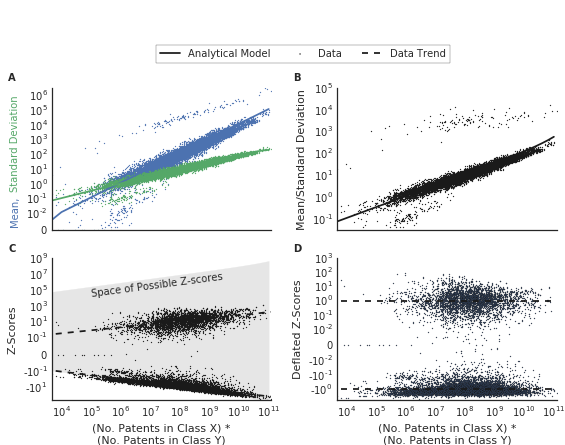

In [56]:
if class_system=='IPC':
    measure = 'Direct Citation'
    annotate_coord = (-.2, 1.05)
    panel_label = "A"

    fig = z_score_inflation_plot(measure, model=True, plot_legend=True, linthreshy=.01)

    figures.append(fig)
    if save_as_manuscript_figures:
        filename = 'Z_Score_Inflation_%s'%measure.replace("\n", "_").replace(" ", "_")
    #     savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
        savefig(figures_directory+filename+'_'+class_system+'.png', bbox_inches='tight', dpi=440)    

In [1]:
if class_system=='IPC':
    for measure in z_scores.items:
        if measure=='Direct Citation':
            continue
        if measure.startswith('Cosine'):
            linthreshy=.0001
        else:
            linthreshy=.1
        annotate_coord = (-.2, 1.05)
        panel_label = "A"

        fig = z_score_inflation_plot(measure, linthreshy=linthreshy, plot_legend=True)
        fig.suptitle(measure, y=1.15)
        figures.append(fig)
        if save_as_manuscript_figures:
            filename = 'Z_Score_Inflation_%s'%measure.replace("\n", " ").replace(" ", "_").replace(".", "").replace("'", "").replace(",", "")
            savefig(figures_directory+filename+'_'+class_system+'.png', bbox_inches='tight', dpi=440)    

In [32]:
### Throw away the undeflated z-scores and use the deflated z-scores from now on.
z_scores = deflated_z_scores

In [361]:
if class_system == 'IPC':
    class_labels = pd.read_csv(data_directory+'class_labels_%s.csv'%class_system).set_index('Class')
    from scipy.stats import scoreatpercentile
    high_empirical = scoreatpercentile(off_diagonal(empirical['Direct Citation']), 97)
    low_normalized = scoreatpercentile(off_diagonal(z_scores['Direct Citation']), 3)
    xs, ys = where(((empirical['Direct Citation']>=high_empirical) * 
                        (z_scores['Direct Citation']<=low_normalized)).values)
    for x, y in zip(xs, ys):
        if x==y:
            continue
        print("From %s to %s"%(class_labels.ix[empirical.major_axis[x], 'Class_label'], 
              class_labels.ix[empirical.major_axis[y], 'Class_label'])) 
        print("Citations: %i, Controls mean: %.2f, Controls std: %.2f: Z-Score: %.2f"%(empirical['Direct Citation'].iloc[x,y],
                                              rand_mean['Direct Citation'].iloc[x,y],
                                              rand_std['Direct Citation'].iloc[x,y],
                                             z_scores['Direct Citation'].iloc[x,y]))

From Layered Products to Measuring & Testing
Citations: 6438, Controls mean: 25005.34, Controls std: 146.02: Z-Score: -2.36


/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/pandas/computation/expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


Correlation of proximity measures with each other, before and after normalizing
===

In [33]:
remove_empty_classes(empirical)
remove_empty_classes(z_scores)

In [34]:
from scipy.stats import pearsonr, spearmanr

def _remove_leading_zero(value, string):
    if 1 > value > -1:
        string = string.replace('0', '', 1)
    return string


class MyFloat(float):
    def __str__(self):
        string = super().__str__()
        return _remove_leading_zero(self, string)

    def __format__(self, format_string):
        string = super().__format__(format_string)
        return _remove_leading_zero(self, string)

In [35]:
link_types = empirical.items.values.tolist()#+['Number of Patents']

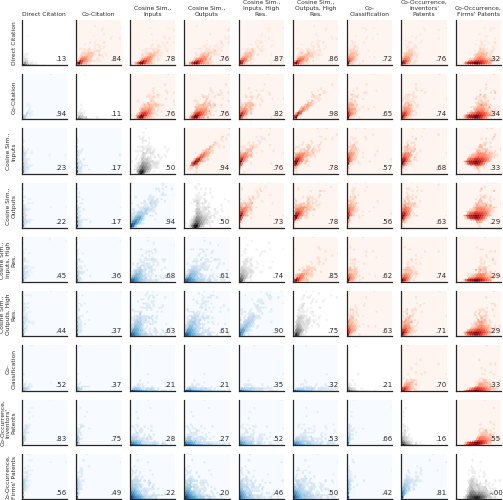

In [126]:
if class_system=='IPC':
    sns.set_style("white")

    fig = figure(figsize=(fig_two_col, fig_two_col))

    nrows = len(link_types)
    ncols = len(link_types)
    this_ax = 0

    s = 1
    this_fontsize = 6
    from textwrap import wrap
    for i in range(len(link_types)):
        for j in range(len(link_types)):

            this_ax += 1

            ax = fig.add_subplot(nrows, ncols, this_ax)
            if i==0:
                ax.set_title(link_types[j], fontsize=this_fontsize)
            if j==0:
                ax.set_ylabel(link_types[i], fontsize=this_fontsize)

            if i<j:
                normalized=True
                color='Reds'#'red'
            elif i>j:
                normalized=False
                color='Blues'#'blue'
            if i==j:
                try:
                    vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
                    vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
                except IndexError:
                    ax.set_frame_on(False)
                    ax.set_yticks([])
                    ax.set_xticks([])
                    continue
                color='Greys'
            else:
                try:
                    if normalized:
                        vals_i = off_diagonal(z_scores.iloc[i].fillna(0).values)
                    else:
                        vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
                except IndexError:        
                    if i==ncols-1:
                        vals_i = off_diagonal(patent_count_links)
                try:
                    if normalized:
                        vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
                    else:
                        vals_j = off_diagonal(empirical.iloc[j].fillna(0).values)
                except IndexError:        
                    if j==ncols-1:
                        vals_j = off_diagonal(patent_count_links)
            ax.hexbin(vals_j, vals_i, bins='log', gridsize=20, cmap=color)#, color=color, gridsize=10)#, s=s)
    #           ax.scatter(vals_j, vals_i, color=color, s=s)


            ax.text(0.75,.1,
                    '{:.2f}'.format(MyFloat(pearsonr(vals_j,vals_i)[0])),
                    transform=ax.transAxes, fontsize=7)
    #         ax.set_yscale('symlog')
    #         ax.set_xscale('symlog')        
            sns.despine()
            ax.set_yticks([])
            ax.set_xticks([])
            pretty_axis_labels(wraplength=15, fontsize=this_fontsize)
            pretty_titles(wraplength=15, fontsize=this_fontsize)

    fig.subplots_adjust(top=.95, left=.05)
    figures.append(fig)
    if save_as_manuscript_figures:
        filename = 'Measure_Comparison_Hex_Plots'
        savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight')

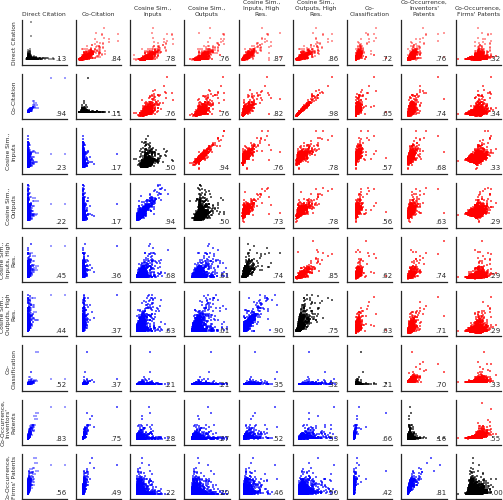

In [127]:
if class_system=='IPC':
    sns.set_style("white")

    fig = figure(figsize=(fig_two_col, fig_two_col))

    nrows = len(link_types)
    ncols = len(link_types)
    this_ax = 0

    s = 1
    this_fontsize = 6
    from textwrap import wrap
    for i in range(len(link_types)):
        for j in range(len(link_types)):

            this_ax += 1

            ax = fig.add_subplot(nrows, ncols, this_ax)
            if i==0:
                ax.set_title(link_types[j], fontsize=this_fontsize)
            if j==0:
                ax.set_ylabel(link_types[i], fontsize=this_fontsize)

            if i<j:
                normalized=True
                color='red'
            elif i>j:
                normalized=False
                color='blue'
            if i==j:
                try:
                    vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
                    vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
                except IndexError:
                    ax.set_frame_on(False)
                    ax.set_yticks([])
                    ax.set_xticks([])
                    continue
                color='black'
            else:
                try:
                    if normalized:
                        vals_i = off_diagonal(z_scores.iloc[i].fillna(0).values)
                    else:
                        vals_i = off_diagonal(empirical.iloc[i].fillna(0).values)
                except IndexError:        
                    if i==ncols-1:
                        vals_i = off_diagonal(patent_count_links)
                try:
                    if normalized:
                        vals_j = off_diagonal(z_scores.iloc[j].fillna(0).values)
                    else:
                        vals_j = off_diagonal(empirical.iloc[j].fillna(0).values)
                except IndexError:        
                    if j==ncols-1:
                        vals_j = off_diagonal(patent_count_links)
    #         ax.hexbin(vals_j, vals_i, bins='log', gridsize=20, cmap=color)#, color=color, gridsize=10)#, s=s)
            ax.scatter(vals_j, vals_i, color=color, s=s)


            ax.text(0.75,.1,
                    '{:.2f}'.format(MyFloat(pearsonr(vals_j,vals_i)[0])),
                    transform=ax.transAxes, fontsize=7)
    #         ax.set_yscale('symlog')
    #         ax.set_xscale('symlog')        
            sns.despine()
            ax.set_yticks([])
            ax.set_xticks([])
            pretty_axis_labels(wraplength=15, fontsize=this_fontsize)
            pretty_titles(wraplength=15, fontsize=this_fontsize)

    fig.subplots_adjust(top=.95, left=.05)
    figures.append(fig)
    if save_as_manuscript_figures:
        filename = 'Measure_Comparison_Scatter_Plots'
        savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight')

In [36]:
from scipy.stats import pearsonr

def correlate_measures(networks,
                      correlation=pearsonr,
                      use_absolute=True,
                      link_types=None):
    if link_types is None:        
        link_types = networks.items.values.tolist()#+['Number of Patents']#['Number of Citing Patents', 'Number of Cited Patents']
        #link_types = [link for link in link_types if 'Jaccard' not in link]


    data_correlations = pd.DataFrame(index=link_types,
                                     columns=link_types)

    comparisons_to_make = []
    for i in range(len(link_types)):
        for j in range((i+1),len(link_types)):
            comparisons_to_make.append((link_types[i], link_types[j]))

    def g(X):
        values_to_correlate = []
        for x in X:
            if x=='Number of Citing Patents':
                vals = citing_patent_count_links
            elif x=='Number of Cited Patents':
                vals = cited_patent_count_links
            elif x=='Number of Patents':
                vals = patent_count_links

            else:
                vals = networks.ix[x].fillna(0).values
            vals = off_diagonal(vals)
            values_to_correlate.append(vals)
        return correlation(values_to_correlate[0], values_to_correlate[1])[0]

    correlations = list(map(g, comparisons_to_make))

    for i in range(len(correlations)):
        data_correlations.ix[comparisons_to_make[i]] = correlations[i]
        data_correlations.ix[comparisons_to_make[i][::-1]] = correlations[i]

    data_correlations = data_correlations.astype('float')
#     data_correlations.index = [x.replace("\n"," ") for x in data_correlations.index]
#     data_correlations.columns = [x.replace("\n"," ") for x in data_correlations.columns]

    if use_absolute:
        data_correlations = abs(data_correlations)
    return data_correlations

In [37]:
from scipy.stats import spearmanr
correlations_empirical = correlate_measures(empirical)
correlations_z_scores = correlate_measures(z_scores)
correlations_empirical_ranked = correlate_measures(empirical,correlation=spearmanr)
correlations_z_scores_ranked = correlate_measures(z_scores,correlation=spearmanr)

In [ ]:
from matplotlib.colors import LogNorm, Normalize

def plot_correlations(data_correlations, ax,
                      show_x=True,
                      show_y=True,
                      norm=Normalize,
                      vmin=0.0,
                      vmax=1.0,
                     use_absolute=True):       

    labels = [x.replace("\n"," ") for x in data_correlations.index]
#    data_correlations.columns = [x.replace("\n"," ") for x in data_correlations.columns]

    if use_absolute:
        data_correlations = abs(data_correlations)
    im = ax.imshow(data_correlations,
                   'viridis', 
                   interpolation='nearest',
                   norm=norm(vmin=vmin, vmax=vmax),
                  )

    #ax.xaxis.tick_top()

    f = lambda x: x.replace("_", " ").replace("\n"," ")[:45]
    _ = xticks(range(len(labels)), list(map(f, labels)), rotation=90, ha='center')
    _ = yticks(range(len(labels)), list(map(f, labels)))
    
    if not show_y:
        ax.set_yticklabels([])
    if not show_x:
        ax.set_xticklabels([])
    return im

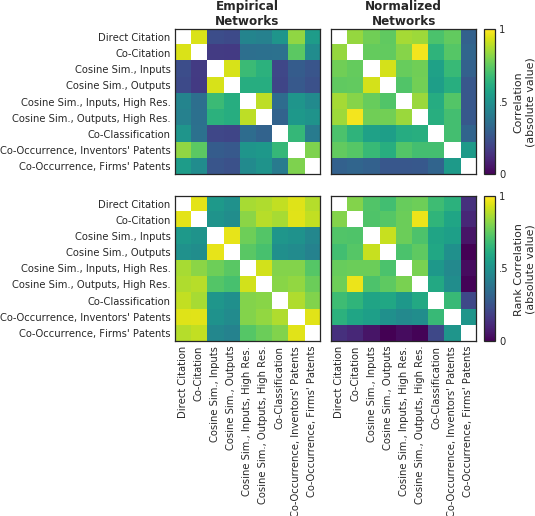

In [397]:
sns.set_style("white")

fig = figure(figsize=(fig_two_col, fig_two_col/1.618))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

nrows = 2
ncols = 2
    
ax1 = fig.add_subplot(nrows, ncols,1)
im_empirical = plot_correlations(correlations_empirical,
                                                ax1,
                                                norm=Normalize,
                                                show_x=False,
                                                show_y=True,
                                               )


ax2 = fig.add_subplot(nrows, ncols,2)
im_empirical_z_scores = plot_correlations(correlations_z_scores,
                                                ax2,
                                                norm=Normalize,
                                                show_x=False,
                                                show_y=False,
                                               )


ax3 = fig.add_subplot(nrows, ncols,3)
im_empirical_ranked = plot_correlations(correlations_empirical_ranked,
                                                ax3,
                                                norm=Normalize,
                                                show_x=True,
                                                show_y=True,
                                               )


ax4 = fig.add_subplot(nrows, ncols,4)
im_empirical_z_scores_ranked = plot_correlations(correlations_z_scores_ranked,
                                                ax4,
                                                norm=Normalize,
                                                show_x=True,
                                                show_y=False,
                                               )


fig.subplots_adjust(hspace=.15, wspace=-.55)

ax1.set_title('Empirical\nNetworks', weight='bold')
ax2.set_title('Normalized\nNetworks', weight='bold')


axins = inset_axes(ax2,
                   width="8%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=3,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )

cbar = colorbar(im_empirical_z_scores,
                cax=axins,
                orientation='vertical',
                label="Correlation\n(absolute value)",
               ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", ".5", "1"])

# ax3.set_xlabel('Empirical Networks', weight='bold')
# ax4.set_xlabel('Normalized Networks', weight='bold')

axins = inset_axes(ax4,
                   width="8%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=3,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax4.transAxes,
                   borderpad=0,
                   )

cbar = colorbar(im_empirical_z_scores_ranked,
             cax=axins,
             orientation='vertical',
             label="Rank Correlation\n(absolute value)",
               ticks=[0, 0.5, 1])
cbar.ax.set_yticklabels(["0", ".5", "1"])

#fig.tight_layout()
figures.append(fig)

# if save_as_manuscript_figures:
#     filename = 'Network_Correlations'
#     savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:1718: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


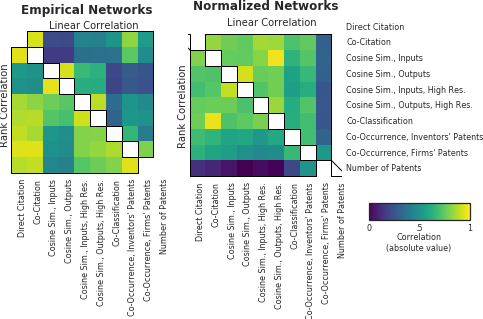

In [398]:
sns.set_style("white")

fig = figure(figsize=(fig_two_col, fig_two_col/1.5))#618))

nrows = 1
ncols = 2
    
ax = fig.add_subplot(nrows, ncols,1)


A = abs(correlations_empirical)
N = A.shape[0]

mask =  tri(A.shape[0], k=-1)
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'viridis', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

A = abs(correlations_empirical_ranked)
mask =  tri(A.shape[0], k=-1).T
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'viridis', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

import matplotlib.patches as patches
line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
        [(N - 1 - i - j, i + 1) for i in range(N - 1) for j in (0, 1)])
lines = [line, [(N - x, N - y) for x, y in line]]
for line in lines:
    path = patches.Polygon(line, facecolor='none', edgecolor='black',
                           linewidth=1, closed=True, joinstyle='round')
    ax.add_patch(path)


ylabel('Rank Correlation', fontsize=10, labelpad=0, y=.48)
xlabel('Linear Correlation', fontsize=10, labelpad=1, x=.54)
ax.xaxis.set_label_position("top")

ax.set_title('Empirical Networks', fontsize=12,y=1.08, weight='bold')

margin = 0.09
ax.set_xlim(-margin, N + margin)
ax.set_ylim(-margin, N + margin)
sns.despine(left=True, bottom=True, right=True)


ax.yaxis.tick_right()
f = lambda x: x.replace("_", " ").replace("\n", " ")

labels = empirical.items.values.tolist()+['Number of Patents']

_ = xticks(.7+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=8)

yticks([])


ax = fig.add_subplot(nrows, ncols,2)

A = abs(correlations_z_scores)
N = A.shape[0]

mask =  tri(A.shape[0], k=-1)
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'viridis', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

A = abs(correlations_z_scores_ranked)
mask =  tri(A.shape[0], k=-1).T
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'viridis', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

import matplotlib.patches as patches
line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
        [(N - 1 - i - j, i + 1) for i in range(10 - 1) for j in (0, 1)])
lines = [line, [(N - x, N - y) for x, y in line]]
for line in lines:
    path = patches.Polygon(line, facecolor='none', edgecolor='black',
                           linewidth=1, closed=True, joinstyle='round')
    ax.add_patch(path)


ylabel('Rank Correlation', fontsize=10, labelpad=0, y=.48)
xlabel('Linear Correlation', fontsize=10, labelpad=1, x=.54)
ax.xaxis.set_label_position("top")

ax.set_title('Normalized Networks', fontsize=12,y=1.08, weight='bold')

margin = 0.09
ax.set_xlim(-margin, N + margin)
ax.set_ylim(-margin, N + margin)
sns.despine(left=True, bottom=True, right=True)


ax.yaxis.tick_right()
f = lambda x: x.replace("_", " ").replace("\n", " ")

labels = empirical.items.values.tolist()+['Number of Patents']

_ = xticks(.7+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=8)
_ = yticks(.5+arange(shape(labels)[0]), list(map(f, labels))[::-1], va='center', fontsize=8)


ax2 = fig.add_axes([.75, 0.3, 0.2, 0.05])
norm = Normalize(vmin=0, vmax=1)

# ax2 = inset_axes(ax,
#                 width="70%", # width = 10% of parent_bbox width
#                 height="10%", # height : 50%
#                 loc=1,
#                 bbox_to_anchor=(.02, .02, 1, 1),
#                bbox_transform=ax.transAxes,
#                borderpad=0,
#                    )

cbar = mpl.colorbar.ColorbarBase(ax2, 
                                 cmap=cm.viridis,
                                 norm=norm,
                                 orientation='horizontal',
                                 label='Correlation\n(absolute value)',
                                ticks=[0, 0.5, 1])

cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel('Correlation\n(absolute value)', fontsize=8, labelpad=0)
cbar.ax.set_xticklabels(["0", ".5", "1"])
# figures.append(fig)
fig.tight_layout()
fig.subplots_adjust(bottom=.3, wspace=None, top=1, hspace=None, left=None, right=None)




# if save_as_manuscript_figures:
#     filename = 'Network_Correlations_Combined'
#     savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


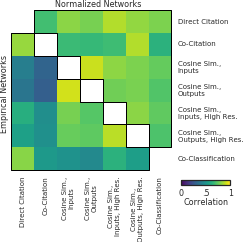

In [38]:
sns.set_style("white")

fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))

nrows = 1
ncols = 1

metrics_for_matrix = ['Direct Citation', 
                      'Co-Citation',                     
                      'Cosine Sim.,\nInputs',
                      'Cosine Sim.,\nOutputs',
                      'Cosine Sim.,\nInputs, High Res.',
                      'Cosine Sim.,\nOutputs, High Res.',
                      'Co-Classification',
                      ]
#                       'Number of Patents']

ax = fig.add_subplot(nrows, ncols,1)


A = abs(correlations_z_scores.ix[metrics_for_matrix][metrics_for_matrix])
N = A.shape[0]

mask =  tri(A.shape[0], k=-1)
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'viridis', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

A = abs(correlations_empirical.ix[metrics_for_matrix][metrics_for_matrix])
mask =  tri(A.shape[0], k=-1).T
A = ma.array(A, mask=mask)

im = ax.imshow(A,
               'viridis', 
               interpolation='none',
                vmin=0, vmax=1,
               extent=[0, N, 0, N]
              )

import matplotlib.patches as patches
line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
        [(N - 1 - i - j, i + 1) for i in range(N - 1) for j in (0, 1)])
lines = [line, [(N - x, N - y) for x, y in line]]
for line in lines:
    path = patches.Polygon(line, facecolor='none', edgecolor='black',
                           linewidth=1, closed=True, joinstyle='round')
    ax.add_patch(path)


ylabel('Empirical Networks', fontsize=8, labelpad=0, y=.48)
xlabel('Normalized Networks', fontsize=8, labelpad=1, x=.54)
ax.xaxis.set_label_position("top")

# ax.set_title('Empirical Networks', fontsize=12,y=1.08, weight='bold')

margin = 0.09
ax.set_xlim(-margin, N + margin)
ax.set_ylim(-margin, N + margin)
sns.despine(left=True, bottom=True, right=True)


ax.yaxis.tick_right()
f = lambda x: x.replace("_", " ")#.replace("\n", " ")

labels = metrics_for_matrix
_ = xticks(.5+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=7)
_ = yticks(.5+arange(shape(labels)[0]), list(map(f, labels))[::-1], va='center', fontsize=7)


ax2 = fig.add_axes([.73, 0.25, 0.2, 0.02])
norm = Normalize(vmin=0, vmax=1)

cbar = mpl.colorbar.ColorbarBase(ax2, 
                                 cmap=cm.viridis,
                                 norm=norm,
                                 orientation='horizontal',
                                 label='Correlation\n(absolute value)',
                                ticks=[0, 0.5, 1])

cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel('Correlation',#\n(absolute value)',
                   fontsize=8, labelpad=0)
cbar.ax.set_xticklabels(["0", ".5", "1"])






fig.tight_layout(pad=0)
fig.subplots_adjust(bottom=.3, top=.97, wspace=None, hspace=None, left=None, right=.7)
figures.append(fig)


if save_as_manuscript_figures:
    filename = 'Network_Correlations_Linear'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
    savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight')

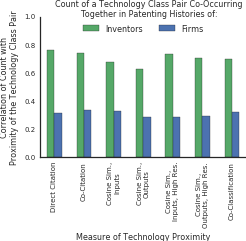

In [386]:
sns.set_style("white")

fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))

nrows = 1
ncols = 1
    
ax = fig.add_subplot(nrows, ncols,1)

measures_to_compare = ['Direct Citation', 
                      'Co-Citation',                       
                      'Cosine Sim.,\nInputs',
                      'Cosine Sim.,\nOutputs',
                      'Cosine Sim.,\nInputs, High Res.',
                      'Cosine Sim.,\nOutputs, High Res.',
                      'Co-Classification',                       
                       ]
data = correlations_z_scores.ix[["Co-Occurrence,\nInventors' Patents",
                          "Co-Occurrence,\nFirms' Patents"]][measures_to_compare].T
data = data.rename(columns={"Co-Occurrence,\nInventors' Patents": "Inventors",
                    "Co-Occurrence,\nFirms' Patents": "Firms"})

# def r_CI95(r, n_classes=121, directed=False):
#     N = n_classes*(n_classes-1)
#     if not directed:
#         N /= 2
#     SE = 1/sqrt(N-3)
#     CI95 = 1.96*SE
#     z_prime = arctanh(r)
#     z_prime_lower, z_prime_upper = z_prime-CI95, z_prime+CI95
#     r_lower, r_upper = tanh(z_prime_lower), tanh(z_prime_upper)
#     return (r_upper-r_lower)/2

# errs = data.applymap(r_CI95)
# errs.ix['Direct Citation'] = data.ix['Direct Citation'].map(lambda x: r_CI95(x,directed=True))
# errs = hstack([zeros((errs.shape[1],1,errs.shape[0])),
#         (errs).values.reshape([errs.shape[1],1,errs.shape[0]])
#         ])

data.plot(kind='bar',
#           yerr=errs,
          ax=ax, 
          legend=False,
          fontsize=7,
         color=['g', 'b'])

ax.set_xlabel("Measure of Technology Proximity",fontsize=8, labelpad=5)
ax.set_ylabel("Correlation of Count with\nProximity of the Technology Class Pair",
#               "& their Co-Occurrence in Behavioral Data",
              fontsize=8)
#Correlation of the Normalized Relatedness between Technology Classes & their Co-Occurrence in Behavioral Data
ax.set_ylim(0,1)
sns.despine(ax=ax)

# bbox_to_anchor=(0., 1, 1., 0.08),     
l = legend(loc="upper center", ncol=2, fontsize=8)
# l = legend(bbox_to_anchor=(0., 1, 1., 0.15), loc="upper center", ncol=2, fontsize=8)
# renderer = fig.canvas.get_renderer()
# shift = max([t.get_window_extent(renderer).width for t in l.get_texts()])
# for t in l.get_texts():
#     t.set_ha('center') # ha is alias for horizontalalignment
#     t.set_position((shift*.45,0))

fig.text(.6, .92, 'Count of a Technology Class Pair Co-Occurring\nTogether in Patenting Histories of:',
        fontsize=8, ha='center')
# title('Count of a Technology Class Pair Co-Occurring\nin Patenting Histories of:', fontsize=8)
fig.tight_layout(pad=0.1)
# fig.subplots_adjust(bottom=.24, wspace=None, top=.98, hspace=None, left=None, right=None)
fig.subplots_adjust(bottom=.35, wspace=None, top=.92, hspace=None, left=None, right=None)
figures.append(fig)
if save_as_manuscript_figures:
    filename = 'Relatedness_Behavior_Correlation'
    savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.svg', bbox_inches='tight')
#     savefig(figures_directory+filename+'_'+class_system+'.eps', bbox_inches='tight')

/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


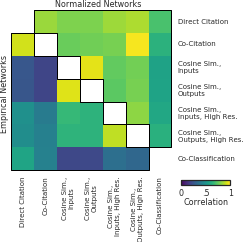

In [64]:
if class_system=='IPC': 
    sns.set_style("white")
    empirical = networks_store['empirical_%s'%class_system].ix[:, 2006]
    empirical = clean_measure_names(empirical)
    drop_diagonal(empirical)
    correlations_empirical_2006 = correlate_measures(empirical)
    
    z_scores_regressed = networks_store['empirical_z_scores_regressed_%s'%class_system].ix[:, 2006]
    z_scores_regressed = clean_measure_names(z_scores_regressed)
    drop_diagonal(z_scores_regressed)
    correlations_normalized_2006 = correlate_measures(z_scores_regressed)
    
    
    fig = figure(figsize=(fig_one_col, fig_one_col))#*1.618))

    nrows = 1
    ncols = 1

    metrics_for_matrix = ['Direct Citation', 
                          'Co-Citation',                     
                          'Cosine Sim.,\nInputs',
                          'Cosine Sim.,\nOutputs',
                          'Cosine Sim.,\nInputs, High Res.',
                          'Cosine Sim.,\nOutputs, High Res.',
                          'Co-Classification',
                          ]
    #                       'Number of Patents']

    ax = fig.add_subplot(nrows, ncols,1)


    A = abs(correlations_normalized_2006.ix[metrics_for_matrix][metrics_for_matrix])
    N = A.shape[0]

    mask =  tri(A.shape[0], k=-1)
    A = ma.array(A, mask=mask)

    im = ax.imshow(A,
                   'viridis', 
                   interpolation='none',
                    vmin=0, vmax=1,
                   extent=[0, N, 0, N]
                  )

    A = abs(correlations_empirical_2006.ix[metrics_for_matrix][metrics_for_matrix])
    mask =  tri(A.shape[0], k=-1).T
    A = ma.array(A, mask=mask)

    im = ax.imshow(A,
                   'viridis', 
                   interpolation='none',
                    vmin=0, vmax=1,
                   extent=[0, N, 0, N]
                  )

    import matplotlib.patches as patches
    line = ([(0, N - 1), (0, 0), (N - 1, 0)] +
            [(N - 1 - i - j, i + 1) for i in range(N - 1) for j in (0, 1)])
    lines = [line, [(N - x, N - y) for x, y in line]]
    for line in lines:
        path = patches.Polygon(line, facecolor='none', edgecolor='black',
                               linewidth=1, closed=True, joinstyle='round')
        ax.add_patch(path)


    ylabel('Empirical Networks', fontsize=8, labelpad=0, y=.48)
    xlabel('Normalized Networks', fontsize=8, labelpad=1, x=.54)
    ax.xaxis.set_label_position("top")

    # ax.set_title('Empirical Networks', fontsize=12,y=1.08, weight='bold')

    margin = 0.09
    ax.set_xlim(-margin, N + margin)
    ax.set_ylim(-margin, N + margin)
    sns.despine(left=True, bottom=True, right=True)


    ax.yaxis.tick_right()
    f = lambda x: x.replace("_", " ")#.replace("\n", " ")

    labels = metrics_for_matrix
    _ = xticks(.5+arange(shape(labels)[0]), list(map(f, labels)), rotation=90, ha='center', fontsize=7)
    _ = yticks(.5+arange(shape(labels)[0]), list(map(f, labels))[::-1], va='center', fontsize=7)


    ax2 = fig.add_axes([.73, 0.25, 0.2, 0.02])
    norm = Normalize(vmin=0, vmax=1)

    cbar = mpl.colorbar.ColorbarBase(ax2, 
                                     cmap=cm.viridis,
                                     norm=norm,
                                     orientation='horizontal',
                                     label='Correlation\n(absolute value)',
                                    ticks=[0, 0.5, 1])

    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_xlabel('Correlation',#\n(absolute value)',
                       fontsize=8, labelpad=0)
    cbar.ax.set_xticklabels(["0", ".5", "1"])
    
    fig.tight_layout(pad=0)
    fig.subplots_adjust(bottom=.3, top=.97, wspace=None, hspace=None, left=None, right=.7)


    if save_as_manuscript_figures:
        filename = 'Network_Correlations_Linear_2006'
        savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight')
        savefig(figures_directory+filename+'_'+class_system+'.png', dpi=440)#, bbox_inches='tight')

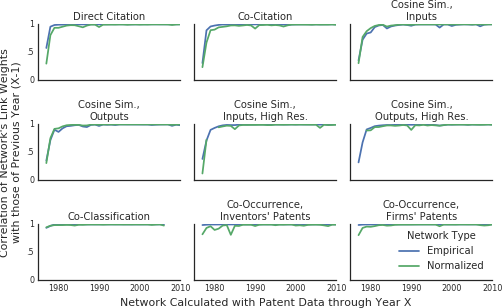

In [343]:
if class_system=='IPC':
    
    def correlate_two_dataframes(i,j):
        return pearsonr(off_diagonal(i.values), off_diagonal(j.values))
    
    empirical = networks_store['empirical_%s'%class_system]
    
    z_scores = networks_store['empirical_z_scores_regressed_%s'%class_system]
    
    fig = figure(figsize=(fig_two_col, fig_two_col/1.618))

    nrows = 3
    ncols = 3
    this_ax = 0
    
    for label in link_types:
        this_ax +=1
        if label == 'Co-Classification':
            years = arange(1976+1,2006+1)
        else:
            years = arange(1976+1,2010+1)
        ax = fig.add_subplot(nrows, ncols, this_ax)
        
        Rs = [correlate_two_dataframes(clean_measure_names(empirical.ix[:,i])[label], 
                                       clean_measure_names(empirical.ix[:,i-1])[label])[0] 
              for i in years]
        ax.plot(years, Rs, label='Empirical')
        
        Rs = [correlate_two_dataframes(clean_measure_names(z_scores.ix[:,i])[label], 
                                       clean_measure_names(z_scores.ix[:,i-1])[label])[0]         
              for i in years]
        ax.plot(years, Rs, label='Normalized')
        
        ax.set_title(label, fontsize=10)
        ax.set_ylim(0,1)
        sns.despine(ax=ax)
        if  this_ax>(nrows*(ncols-1)):
            ax.set_xticks(arange(1980,2010+1,10))
            ax.set_xticklabels(arange(1980,2010+1,10), fontsize=8)
        else:
            ax.set_xticks([])
            
        if this_ax%ncols!=1:
            ax.set_yticks([])
        else:
            ax.set_yticks([0,.5,1])
            ax.set_yticklabels(['0', '.5', '1'], fontsize=8)
        if this_ax%ncols==1 and this_ax==(nrows+1):
            ax.set_ylabel("Correlation of Network's Link Weights\nwith those of Previous Year (X-1)")
        if this_ax==(nrows*ncols-1):
            ax.set_xlabel("Network Calculated with Patent Data through Year X")
        
        if this_ax==(nrows*ncols):
            ax.legend(title='Network Type', loc='lower right')
            
    
#     fig.tight_layout()
#     fig.tight_layout(pad=0)
#     fig.subplots_adjust(hspace=.5)
    fig.subplots_adjust(bottom=.1, top=.92, wspace=.1, hspace=.8, left=.08, right=.98)
    if save_as_manuscript_figures:
        filename = 'Network_Temporal_Stability'
        savefig(figures_directory+filename+'_'+class_system+'.pdf')#, bbox_inches='tight', pad_inches=0)

Direct Citation
Co-Citation
Cosine Sim., Inputs
Cosine Sim., Outputs
Cosine Sim., Inputs, High Res.
Cosine Sim., Outputs, High Res.
Co-Classification
Co-Occurrence, Inventors' Patents
Co-Occurrence, Firms' Patents
Co-Occurrence, Countries' Patents


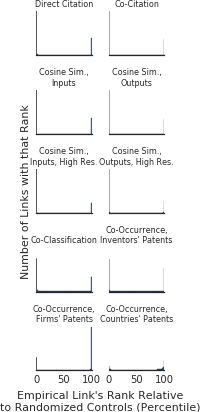

In [325]:
if class_system=='IPC':
    networks_store = pd.HDFStore(data_directory+'Class_Relatedness_Networks/class_relatedness_networks.h5')
    empirical = networks_store['empirical_%s'%class_system].ix[:, target_year]
    empirical = clean_measure_names(empirical, include_country=True)
    remove_empty_classes(empirical)
    drop_diagonal(empirical)

    controls = pd.read_hdf(data_directory+'Class_Relatedness_Networks/class_relatedness_networks_controls_organized_%s.h5'%class_system,
                          'controls_%s'%class_system)
    controls = controls.swapaxes('items', 'labels')    
    controls = clean_measure_names(controls, include_country=True)
    remove_empty_classes(controls)
    drop_diagonal(controls)

    from scipy.stats import percentileofscore

    percentiles = empirical.copy()

    for metric in percentiles.items:
        print(metric.replace("\n", " "))
        for i in empirical.major_axis:
            for j in empirical.minor_axis:
                p = percentileofscore(controls.ix[:, metric, i,j],
                                      empirical.ix[metric,i,j],
                                      kind='weak'
                                      )
                percentiles.ix[metric,i,j] = p

    fig = figure(figsize=(fig_one_col, fig_one_col*1.618))
    n_ax = len(percentiles.items)
    n_cols = 2
    n_rows = round(n_ax/n_cols)
    this_ax = 0
    for metric in percentiles.items:
        this_ax += 1
        ax = fig.add_subplot(n_rows, n_cols, this_ax)
        ax.hist(percentiles.ix[metric].values.ravel(),bins=100,normed=True)
        ax.set_title(metric, fontsize=8)
        ax.set_yticks([])
        if this_ax>n_ax-2:
            ax.set_xticks([0,50,100])
        else:
            ax.set_xticks([])
        sns.despine(left=True)
        xlim(xmin=0, xmax=100)
        ylim(ymin=0, ymax=.55)
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel("Empirical Link's Rank Relative\nto Randomized Controls (Percentile)", labelpad=20)
    ax.set_ylabel("Number of Links with that Rank")
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])


    fig.tight_layout(pad=0)
    fig.subplots_adjust(bottom=.1, top=1,left=.43,right=.95, wspace=.3, hspace=.8)

    if save_as_manuscript_figures:
        filename = 'Country_CoOccurence_Histograms'
        savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight', pad_inches=0)

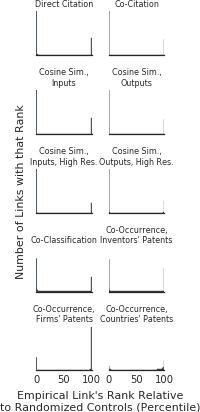

In [329]:
fig = figure(figsize=(fig_one_col, fig_one_col*1.618))
n_ax = len(percentiles.items)
n_cols = 2
n_rows = round(n_ax/n_cols)
this_ax = 0
for metric in percentiles.items:
    this_ax += 1
    ax = fig.add_subplot(n_rows, n_cols, this_ax)
    ax.hist(percentiles.ix[metric].values.ravel(),bins=100,normed=True)
    ax.set_title(metric, fontsize=8)
    ax.set_yticks([])
    if this_ax>n_ax-2:
        ax.set_xticks([0,50,100])
    else:
        ax.set_xticks([])
    sns.despine(left=True)
    xlim(xmin=0, xmax=100)
    ylim(ymin=0, ymax=.55)
ax = fig.add_subplot(1,1,1)
ax.set_xlabel("Empirical Link's Rank Relative\nto Randomized Controls (Percentile)", labelpad=20)
ax.set_ylabel("Number of Links with that Rank", labelpad=10)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])


fig.tight_layout(pad=0)
fig.subplots_adjust(bottom=.1, top=1,left=.43,right=.95, wspace=.3, hspace=.8)

if save_as_manuscript_figures:
    filename = 'Country_CoOccurence_Histograms'
    savefig(figures_directory+filename+'_'+class_system+'.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
store = pd.HDFStore(data_directory+'occurrences_organized.h5')
firms = store['entity_classes_Firm_%s'%class_system]
countries = store['entity_classes_Country_%s'%class_system]
inventors = store['entity_classes_Inventor_%s'%class_system]
print("%i firms"%firms['Firm'].nunique())
print("%i inventors"%inventors['Inventor'].nunique())
print("%i countries"%countries['Country'].nunique())

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
plots = PdfPages(figures_directory+'Manuscript_Figures_%s.pdf'%class_system)
for i in figures:
    print(i)
    plots.savefig(i, bbox_inches='tight')
plots.close()